In [52]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial

from timeit import default_timer
from utilities3 import *

torch.manual_seed(0)
np.random.seed(0)

################################################################
# fourier layer
################################################################
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d, self).__init__()

        """

        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.fc0 = nn.Linear(12, self.width) # input channel is 3: (a(1,x),a(2,x),...,a(10,x), x, t)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.bn0 = torch.nn.BatchNorm3d(self.width)
        self.bn1 = torch.nn.BatchNorm3d(self.width)
        self.bn2 = torch.nn.BatchNorm3d(self.width)
        self.bn3 = torch.nn.BatchNorm3d(self.width)


        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        batchsize = x.shape[0]
        size_x, size_y = x.shape[1], x.shape[2] #x for S, y for t

        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        x1 = self.conv0(x)
        x2 = self.w0(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = x1 + x2
        x = F.relu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = x1 + x2
        x = F.relu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = x1 + x2
        x = F.relu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = x1 + x2

        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

## First Test: Extrapolation
T = 2

time_steps = np.linsapce(0,T,50)

Input data: C(S) for the first 10 time steps

Output data: C(S) for the last 40 time steps

In [103]:
################################################################
# configs
################################################################
TRAIN_PATH = 'data/BS_data2.mat'
TEST_PATH = 'data/BS_data2.mat'

ntrain = 1000
ntest = 100

batch_size = 20
learning_rate = 0.001

epochs = 500
step_size = 100
gamma = 0.5

modes = 12
width = 32

sub = 1
S = 64 // sub
T_in = 10
T = 40

path = 'BS_test2'
path_model = 'model/'+path
t1 = default_timer()
################################################################
# load data and data normalization
################################################################
reader = MatReader(TRAIN_PATH)
train_a = reader.read_field('u')[:ntrain,::sub,:T_in]
train_u = reader.read_field('u')[:ntrain,::sub,T_in:T+T_in]

reader = MatReader(TEST_PATH)
test_a = reader.read_field('u')[-ntest:,::sub,:T_in]
test_u = reader.read_field('u')[-ntest:,::sub,T_in:T+T_in]

print(train_u.shape)
print(test_u.shape)
assert (S == train_u.shape[-2])
assert (T == train_u.shape[-1])

a_normalizer = UnitGaussianNormalizer(train_a)
train_a = a_normalizer.encode(train_a)
test_a = a_normalizer.encode(test_a)

y_normalizer = UnitGaussianNormalizer(train_u)
train_u = y_normalizer.encode(train_u)

train_a = train_a.reshape(ntrain,S,1,T_in).repeat([1,1,T,1])
test_a = test_a.reshape(ntest,S,1,T_in).repeat([1,1,T,1])


# pad locations (x,y,t)
gridx = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
gridx = gridx.reshape(1, S,  1, 1).repeat([1, 1, T, 1])
gridt = torch.tensor(np.linspace(0, 2, T+1)[1:], dtype=torch.float)
gridt = gridt.reshape(1, 1,  T, 1).repeat([1, S,  1, 1])

train_a = torch.cat((gridx.repeat([ntrain,1,1,1]),
                       gridt.repeat([ntrain,1,1,1]), train_a), dim=-1)
test_a = torch.cat((gridx.repeat([ntest,1,1,1]),
                       gridt.repeat([ntest,1,1,1]), test_a), dim=-1)


train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=batch_size, shuffle=False)

t2 = default_timer()

print('preprocessing finished, time used:', t2-t1)
device = torch.device('cuda')
################################################################
# training and evaluation
################################################################
model = FNO2d(modes, modes, width).cuda()
print(count_params(model))

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)
y_normalizer.cuda()
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    train_mse = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x).view(batch_size, S, T)

        mse = F.mse_loss(out, y, reduction='mean')

        y = y_normalizer.decode(y)
        out = y_normalizer.decode(out)
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward()

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x).view(batch_size, S, T)
            out = y_normalizer.decode(out)
            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest

    t2 = default_timer()
    print(ep, t2-t1, train_mse, train_l2, test_l2)

torch.save(model, path_model)

pred = torch.zeros(test_u.shape)
benchmark = torch.zeros(test_u.shape)
inputs = torch.zeros(test_a.shape)
index = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=1, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        x, y = x.cuda(), y.cuda()

        out = model(x).squeeze()
        out = y_normalizer.decode(out)
        pred[index] = out
        benchmark[index] = y.squeeze()
        inputs[index] = x
        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        print(index, test_l2)
        index = index + 1

scipy.io.savemat('pred/'+path+'.mat', mdict={'pred': pred.cpu().numpy(),
                                             'benchmark':benchmark.cpu().numpy(),
                                              'inputs':inputs.cpu().numpy()})

torch.Size([4500, 64, 40])
torch.Size([500, 64, 40])
preprocessing finished, time used: 1.7546328000007634
1188897
0 3.141222399999606 0.1837330046130551 0.2688577134476768 0.17926093101501464
1 3.0937150999998266 0.07207320892148547 0.09551524533165826 0.05269642132520676
2 2.9825236999986373 0.05432846155431535 0.057533877372741696 0.03822400051355362
3 2.934990999998263 0.047909334724148114 0.056979322406980726 0.036026535511016845
4 2.950293199999578 0.04383104785035054 0.048666794485516016 0.08236396861076355
5 3.0839015999990806 0.04373560167021222 0.04698323351807065 0.052205969870090484
6 2.9887961000003997 0.04027761602567302 0.0443487348722087 0.024415130972862242
7 2.9603320000005624 0.03780455838888883 0.04780103274186452 0.0656774880886078
8 3.011436299999332 0.03791649353173044 0.052420014335049524 0.03735315853357315
9 2.996473600000172 0.03569903437462118 0.03465547595421473 0.036647685766220094
10 3.0437141000002157 0.03540232191897101 0.036885567900207306 0.0499469618

The price predicted from the model for the last 40 time steps(blue dots) and the ground truth(colored surface)

Text(0.5, 0, 'S')

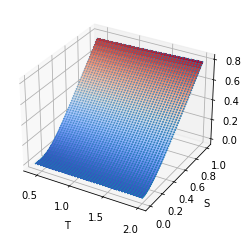

In [25]:
pred = scipy.io.loadmat('pred/BS_test2.mat')
predicted = pred['pred']
groundtruth = pred['benchmark']

from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
tempx = np.linspace(0,2,50)
t = tempx[10:]
s = np.linspace(0,1,64)
N = 65
[tgrid,sgrid] = np.meshgrid(t,s)
ax.plot_surface(tgrid,sgrid,groundtruth[N,:,:].reshape(64,40),cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,label = 'groundtruth')
ax.scatter(tgrid,sgrid,predicted[N,:,:].reshape(64,40),s=1,label = 'predicted')

ax.set_xlabel('T')
ax.set_ylabel('S')

#ax.view_init(45, 45)

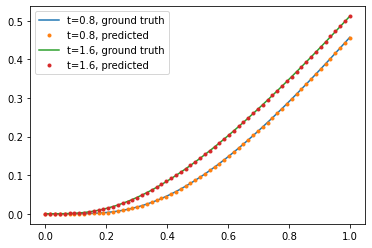

In [38]:
plt.figure()
N = 10
t = 10
plt.plot(s,groundtruth[N,:,t],label = 't=0.8, ground truth')
plt.plot(s,predicted[N,:,t],'.',label = 't=0.8, predicted')

t = 30
plt.plot(s,groundtruth[N,:,t],label = 't=1.6, ground truth')
plt.plot(s,predicted[N,:,t],'.',label = 't=1.6, predicted')

plt.legend()
plt.show()

In [38]:
################################################################
# configs
################################################################
TRAIN_PATH = 'data/BS_data2.mat'
TEST_PATH = 'data/BS_data2.mat'

ntrain = 1000
ntest = 100

batch_size = 20
learning_rate = 0.001

epochs = 500
step_size = 100
gamma = 0.5

modes = 12
width = 32

sub = 1
S = 64 // sub

T_in = 10
T = 40

index_train_u = np.ones((50,),dtype=bool)
index_train_u[::5] = False
index_train_a = ~index_train_u
#temp = np.linspace(0,49,50)
#index_train_a = temp[index_train_a]
#index_train_u = temp[index_train_u]


path = 'BS_test2_inter'
path_model = 'model/'+path
t1 = default_timer()
################################################################
# load data and data normalization
################################################################
reader = MatReader(TRAIN_PATH)
train_a = reader.read_field('u')[:ntrain,::sub,index_train_a]
train_u = reader.read_field('u')[:ntrain,::sub,index_train_u]

reader = MatReader(TEST_PATH)
test_a = reader.read_field('u')[-ntest:,::sub,index_train_a]
test_u = reader.read_field('u')[-ntest:,::sub,index_train_u]

print(train_u.shape)
print(test_u.shape)
print(test_a.shape)
print(train_a.shape)
#assert (S == train_u.shape[-2])
#assert (T == train_u.shape[-1])

a_normalizer = UnitGaussianNormalizer(train_a)
train_a = a_normalizer.encode(train_a)
test_a = a_normalizer.encode(test_a)

y_normalizer = UnitGaussianNormalizer(train_u)
train_u = y_normalizer.encode(train_u)

train_a = train_a.reshape(ntrain,S,1,T_in).repeat([1,1,T,1])
test_a = test_a.reshape(ntest,S,1,T_in).repeat([1,1,T,1])


# pad locations (x,y,t)
gridx = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
gridx = gridx.reshape(1, S,  1, 1).repeat([1, 1, T, 1])
gridt = torch.tensor(np.linspace(0, 2, T+1)[1:], dtype=torch.float)
gridt = gridt.reshape(1, 1,  T, 1).repeat([1, S,  1, 1])

train_a = torch.cat((gridx.repeat([ntrain,1,1,1]),
                       gridt.repeat([ntrain,1,1,1]), train_a), dim=-1)
test_a = torch.cat((gridx.repeat([ntest,1,1,1]),
                       gridt.repeat([ntest,1,1,1]), test_a), dim=-1)


train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=batch_size, shuffle=False)

t2 = default_timer()

print('preprocessing finished, time used:', t2-t1)
device = torch.device('cuda')
################################################################
# training and evaluation
################################################################
model = FNO2d(modes, modes, width).cuda()
print(count_params(model))

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)
y_normalizer.cuda()
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    train_mse = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x).view(batch_size, S, T)

        mse = F.mse_loss(out, y, reduction='mean')

        y = y_normalizer.decode(y)
        out = y_normalizer.decode(out)
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward()

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x).view(batch_size, S, T)
            out = y_normalizer.decode(out)
            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest

    t2 = default_timer()
    print(ep, t2-t1, train_mse, train_l2, test_l2)

torch.save(model, path_model)

pred = torch.zeros(test_u.shape)
benchmark = torch.zeros(test_u.shape)
inputs = torch.zeros(test_a.shape)
index = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=1, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        x, y = x.cuda(), y.cuda()

        out = model(x).squeeze()
        out = y_normalizer.decode(out)
        pred[index] = out
        benchmark[index] = y.squeeze()
        inputs[index] = x
        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        print(index, test_l2)
        index = index + 1

scipy.io.savemat('pred/'+path+'.mat', mdict={'pred': pred.cpu().numpy(),
                                             'benchmark':benchmark.cpu().numpy(),
                                              'inputs':inputs.cpu().numpy()})



torch.Size([1000, 64, 40])
torch.Size([100, 64, 40])
torch.Size([100, 64, 10])
torch.Size([1000, 64, 10])
preprocessing finished, time used: 1.6152715999996872
1188897
0 0.6593083000007027 0.5919980806112289 0.5594322459697724 0.23795029640197754
1 0.6372411000011198 0.04975706271827221 0.11456804955005646 0.12232266426086426
2 0.6282850000006874 0.035425115860998634 0.08698419523239136 0.11324669480323792
3 0.625798199998826 0.032351309154182675 0.06887353998422623 0.07307294130325317
4 0.627876999998989 0.030446572322398426 0.0556220985352993 0.04378042787313461
5 0.6764118999999482 0.030798417814075947 0.06520593157410622 0.06295401573181153
6 0.6372455999990052 0.0301807121373713 0.06504626253247262 0.0508616179227829
7 0.6370122999996966 0.03274038957431912 0.03423641061782837 0.03241024434566498
8 0.6307565999995859 0.03356167670339346 0.04613922503590584 0.06075088739395142
9 0.6276404000000184 0.04024118188768625 0.06269701072573662 0.05354777276515961
10 0.6259695999997348 0.0

## The Second Test: Interpolation
T = 2

time_steps = np.linsapce(0,T,50)

Input data: C(S) for the evenly spaced 10 time steps time_steps[::5]

Output data: C(S) for the remaining 40 time steps

Text(0.5, 0, 'S')

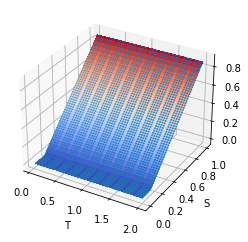

In [49]:
pred = scipy.io.loadmat('pred/BS_test2_inter.mat')
predicted = pred['pred']
groundtruth = pred['benchmark']

from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
index_train_u = np.ones((50,),dtype=bool)
index_train_u[::5] = False
index_train_a = ~index_train_u
tempx = np.linspace(0,2,50)
t = tempx[index_train_u]
s = np.linspace(0,1,64)
N = 40
[tgrid,sgrid] = np.meshgrid(t,s)
ax.plot_surface(tgrid,sgrid,groundtruth[N,:,:].reshape(64,40),cmap=cm.coolwarm,
                       linewidth=1, antialiased=False,label = 'groundtruth')
ax.scatter(tgrid,sgrid,predicted[N,:,:].reshape(64,40),s=1,label = 'predicted')

ax.set_xlabel('T')
ax.set_ylabel('S')

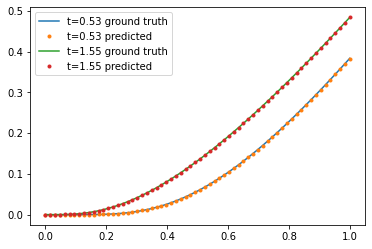

In [51]:
plt.figure()
N = 10
Nt = 10
plt.plot(s,groundtruth[N,:,Nt],label = 't='+'{:.2f}'.format(t[Nt])+' ground truth')
plt.plot(s,predicted[N,:,Nt],'.',label = 't='+'{:.2f}'.format(t[Nt])+' predicted')

Nt = 30
plt.plot(s,groundtruth[N,:,Nt],label = 't='+'{:.2f}'.format(t[Nt])+' ground truth')
plt.plot(s,predicted[N,:,Nt],'.',label = 't='+'{:.2f}'.format(t[Nt])+' predicted')

plt.legend()
plt.show()